In [15]:
!dir
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage.morphology import disk, square, rectangle as rect

from skimage.morphology import(binary_erosion, 
                               binary_dilation,
                               binary_closing,
                               skeletonize,
                               thin
                              )
from skimage.measure import find_contours

from skimage.draw import rectangle
from skimage.filters import threshold_otsu


 Volume in drive C has no label.
 Volume Serial Number is B4DA-B24E

 Directory of C:\Users\mohammed\projects\music-notes-reader

12/24/2020  09:55 PM    <DIR>          .
12/24/2020  09:55 PM    <DIR>          ..
12/05/2020  03:47 PM             1,928 .gitignore
12/05/2020  04:50 PM    <DIR>          .ipynb_checkpoints
12/13/2020  07:54 PM             3,115 commonfunctions.py
12/21/2020  12:57 PM             3,778 commonfunctions.pyc
12/22/2020  02:44 PM             8,437 environment.yml
12/24/2020  01:27 PM    <DIR>          images
12/24/2020  09:55 PM           245,776 part1.ipynb
12/24/2020  03:48 PM             2,196 README.md
12/21/2020  03:43 PM    <DIR>          single-dataset
12/05/2020  03:47 PM           514,072 [IP] Project F2020_ Sheet Music Reader.pdf
12/13/2020  08:00 PM    <DIR>          __pycache__
               7 File(s)        779,302 bytes
               6 Dir(s)  290,851,192,832 bytes free


In [16]:
import cv2


In [55]:
# cv2  common functions
def remove_horizontal_lines(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    gray=255 - thresh
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # for c in cnts:
    #     cv2.drawContours(gray, [c], -1, 255, 2)
    cv2.drawContours(gray, cnts, -1, 255, 2)

    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    result =cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    return result

In [27]:
# common functions

def get_bounding_boxes(img,box_aspect_ratio):
    """
    summary: this function returns
    parameter:
    img: is a binary image for which to find the contours 
    aspect_ratio: is a tuple where (low_aspect_ratio,high_aspect_ratio)
    """
    contours = find_contours(img,.8)
    bounding_boxes=[]
    for contour in contours:
        Xmin= np.min(contour[:,1])
        Xmax=np.max(contour[:,1]) 
        Ymin=np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        if aspect_ratio >= box_aspect_ratio[0] and aspect_ratio <= box_aspect_ratio[1]:
            
            bounding_boxes.append([int(round(Xmin)),int(round(Xmax)),int(round(Ymin)),int(round(Ymax))])
        
    return bounding_boxes
def get_bounded_image(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    return img2
def draw_bounding_boxes(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    show_images([conte,img2], ['bounding_boxes','original segmented'])


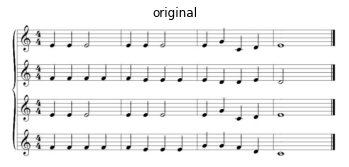

In [58]:
original_image = io.imread('images/music1.JPG')
gray_image = rgb2gray(original_image)
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image
show_images([original_image],['original'])

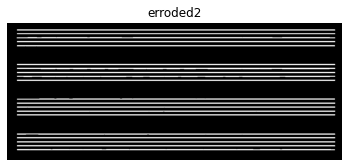

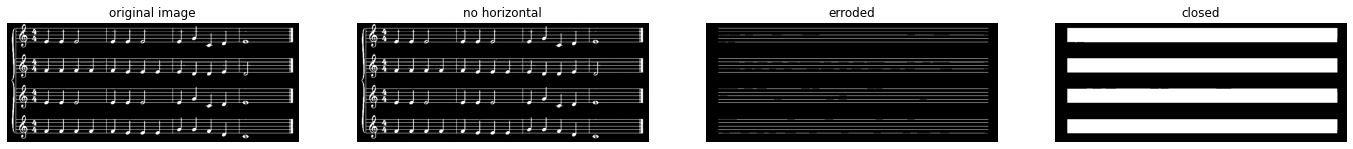

In [20]:
original_image = io.imread('images/music1.JPG')
gray_image = rgb2gray(original_image)
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image
# show_images([inverted_image,erroded_img,closed_img],['original image','erroded','closed'])
rows=1
cols=35
selem = rect(rows,cols)
erroded_img = binary_erosion(inverted_image,selem=selem)
rows=4
cols=35
selem = rect(rows,cols)
erroded_img2 = binary_dilation(erroded_img, selem=selem)
inverted_image2 = inverted_image - erroded_img2

show_images([erroded_img2], ['erroded2'])

rows = 20
cols = 1
selem = rect(rows,cols)
closed_img  = binary_closing(erroded_img, selem = selem)
show_images([inverted_image,inverted_image2,erroded_img,closed_img],['original image','no horizontal','erroded','closed'])

In [21]:
#  calculate the trace bounding boxes
trace_bounding_boxes = get_bounding_boxes(closed_img,(10,4000))
bigger_trace_bounding_boxes = []
trace_images_array = []
division_height=0
trace_height = 0
for box in trace_bounding_boxes:
    trace_height = box[3]-box[2]
    division_height = (trace_height)/4
    division_height = int(np.ceil(division_height)) 
#     division_height *=2
    [Xmin, Xmax, Ymin, Ymax] = [int(round(x)) for x in box]
    Ymin -= 2 * division_height
    Ymin = Ymin if Ymin >0 else 0
    Ymax += 2 * division_height
    bigger_trace_bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])

    trace_images_array.append(gray_image[Ymin:Ymax,Xmin:Xmax])
    

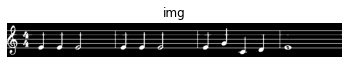

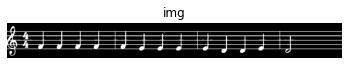

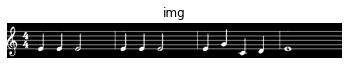

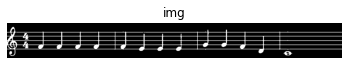

In [44]:
# for each trace segment the individual characters
staff_images = []
gray_staff_images=[]
for trace in bigger_trace_bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = [x for x in trace]
    show_images([inverted_image[Ymin:Ymax,Xmin:Xmax]], ['img'])
    staff_images.append(inverted_image[Ymin:Ymax,Xmin:Xmax])    
    gray_staff_images.append(gray_image[Ymin:Ymax,Xmin:Xmax])


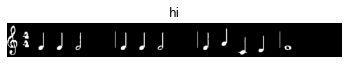

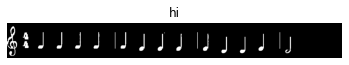

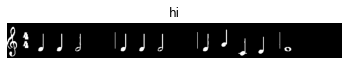

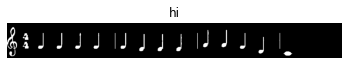

In [59]:
#  remove horizontal lines using normal morphology
all_notes=[]
for trace in bigger_trace_bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = [x for x in trace]
    staff_no_lines = remove_horizontal_lines(original_image[Ymin:Ymax,Xmin:Xmax])
    show_images([staff_no_lines],['hi'])



In [71]:
from skimage import data
from skimage.viewer import ImageViewer

image = original_image
viewer = ImageViewer(image)
viewer.show()

C:\Users\mohammed\anaconda3\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


[]

In [54]:
import cv2

image = cv2.imread('images/music1.JPG')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# gray = gray_staff_images[0]*255
print(gray.shape)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
gray=255 - thresh
# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     cv2.drawContours(gray, [c], -1, 255, 2)
cv2.drawContours(gray, cnts, -1, 255, 2)

# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
result =cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
print(result.shape)
print(result)

break
cv2.imshow('thresh', thresh)
cv2.imshow('detected_lines', detected_lines)
cv2.imshow('image', gray)
cv2.imshow('result', result)
cv2.waitKey()

(563, 1377)
(563, 1377)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


SyntaxError: 'break' outside loop (<ipython-input-54-4844b3ef4da8>, line 24)

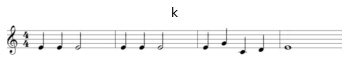

In [46]:
show_images([gray_staff_images[0]],['k'])